# Model Selection

In [120]:
import numpy as np
import pandas as pd
import os

#plotting
import seaborn as sns
import matplotlib.pyplot as plt

#model evaluation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV,  KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, roc_curve, auc

#models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


# random state
SEED = np.random.seed(0)

Load Dataset

In [87]:
# PATHING ASSUMES "Processed Data" file is in the same directory as this file
path = os.path.abspath(r'Processed Data')
dataset = pd.read_csv(str(path))
dataset = dataset.drop('rawContent', axis=1)

# shuffle 
dataset = dataset.sample(frac=1).reset_index(drop=True)
# training on 1/10th of the data
dataset = dataset.iloc[:dataset.shape[0]//6]

dataset.shape
dataset.head()

,replyCount,retweetCount,likeCount,quoteCount,links,media,mentionedUsers,hashtags,Party,Positive,Negative,Neutral,processed text
0,7.0,9.0,77.0,0.0,0,0,0,0,0,1,0,0,proud help direct million fta funding low emis...
1,1.0,1.0,16.0,0.0,0,0,0,0,0,1,0,0,grateful secure federal funding help mundelein...
2,16.0,4.0,10.0,1.0,1,0,0,0,1,0,0,1,http co yhlhatz iz
3,1.0,4.0,11.0,0.0,0,1,6,0,1,1,0,0,discussing improve port operation prdirpuertos...
4,4.0,30.0,90.0,1.0,0,0,0,0,0,0,1,0,seems health expert governor abbott consulted ...


Vectorize Text Data for model training

In [88]:
# Vectorize the processed text column
X = dataset["processed text"]
td = TfidfVectorizer(max_features = 4500)
X = td.fit_transform(X.apply(lambda x: np.str_(x))).toarray()# v.fit_transform(df['Review'].apply(lambda x: np.str_(x)))

# concatenate the other relevant features to the vectorized processed text column
sub_dataset = dataset.drop(['Party', 'processed text'], axis=1)
X = np.concatenate((X, sub_dataset), 1)

# extract ground truth labels
y = dataset["Party"]

Train Test Split

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25,random_state = SEED)

In [90]:

def evaluate_model(clf, X, y, X_test, y_test, graphs=True):
    model = clf.fit(X, y)
    pred = clf.predict(X_test)
    score = clf.score(X_test, y_test)

    # print('\n Accuracy: ', accuracy_score(y_test, pred))


    # Classification Report
    print("\nClassification Report ")
    print('======================================================')
    print(classification_report(y_test, pred))

    if graphs == True:

        #predicted probabilities
        y_pred_proba = model.predict_proba(X_test)[:, 1]

        # Confusion Matrix
        print("\nConfusion Matrix ")
        print('======================================================')
        cm = confusion_matrix(y_test,pred)
        sns.heatmap(cm, annot=True, cmap='rocket')
        plt.xlabel('Predictions')
        plt.ylabel('Actual')
        plt.show()

        
        # ROC AUC curve
        print("\nROC AUC Curve ")
        print('======================================================')
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        sns.set_style('whitegrid')
        sns.set_palette('rocket_r')
        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()


        # Precision Recall Curve
        print("\nPrecision Recall Curve ")
        print('======================================================')
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    
        sns.set_style('whitegrid')
        sns.set_palette('rocket_r')
        plt.plot(recall, precision, label='Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall curve')
        plt.legend()
        plt.show()

    return clf

In [91]:
def k_fold(model,folds):
    # model
    clf = model
    # Create a KFold object with k folds
    kf = KFold(n_splits=folds, shuffle=True, random_state=SEED)

    # mean acc
    a = []
    # Loop over the folds
    for train_idx, test_idx in kf.split(X):
        # Split the data into training and test sets for this fold
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train the classifier on the training set for this fold
        clf.fit(X_train, y_train)
        
        # Predict the labels of the test set for this fold
        y_hat = clf.predict(X_test)
        # Compute the accuracy of the classifier on the test set for this fold
        acc = accuracy_score(y_test, y_hat)
        # Print the accuracy for this fold
        print(f"Fold accuracy: {acc:.3f}")
        a.append(acc)
    print(f"Mean Accuracy: {np.mean(a):.3f}")


Benchmark Naive Bayes

In [92]:
nb = MultinomialNB()
evaluate_model(nb, X_train, y_train, X_test, y_test, graphs=False)


Classification Report 
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     18995
           1       0.80      0.73      0.76     13766

    accuracy                           0.81     32761
   macro avg       0.81      0.80      0.80     32761
weighted avg       0.81      0.81      0.81     32761



MultinomialNB()

Grid Search Naive Bayes


Classification Report 
              precision    recall  f1-score   support

           0       0.82      0.87      0.84     18995
           1       0.80      0.73      0.76     13766

    accuracy                           0.81     32761
   macro avg       0.81      0.80      0.80     32761
weighted avg       0.81      0.81      0.81     32761


Confusion Matrix 


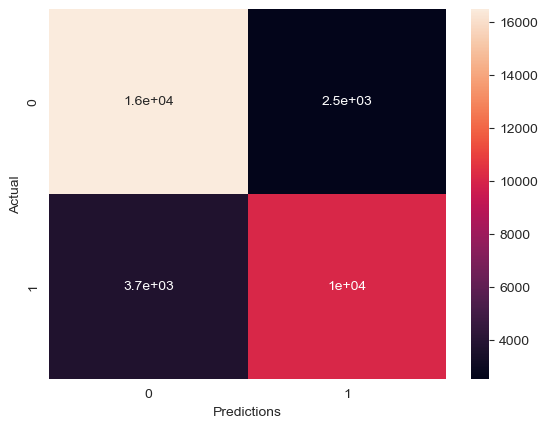


ROC AUC Curve 


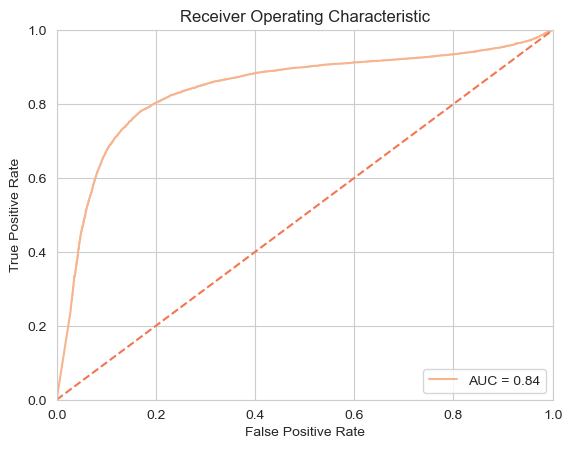


Precision Recall Curve 


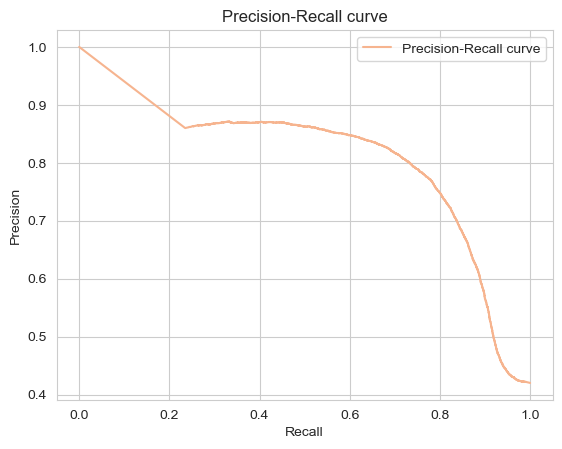

In [126]:
nb = MultinomialNB()

params = {'alpha': [10,1, 0.1, 0.01, 0.001, 0.0001]}

clf = GridSearchCV(nb,params, cv=5)
nb_gc  = evaluate_model(clf, X_train, y_train, X_test, y_test, graphs=True)

In [101]:
print(nb_gc.best_params_)

{'alpha': 0.0001}


K Fold Cross Validation Naive Bayes with Optimal Parameters

In [102]:
k_fold(MultinomialNB(**nb_gc.best_params_),5)

Fold accuracy: 0.807
Fold accuracy: 0.809
Fold accuracy: 0.809
Fold accuracy: 0.807
Fold accuracy: 0.805
Mean Accuracy: 0.807


Benchmark SGD

In [ ]:
sgd = SGDClassifier()
evaluate_model(sgd, X_train, y_train, X_test, y_test, graphs=False)

Grid Search SGD


Classification Report 
              precision    recall  f1-score   support

           0       0.69      0.36      0.47     18995
           1       0.47      0.78      0.58     13766

    accuracy                           0.53     32761
   macro avg       0.58      0.57      0.53     32761
weighted avg       0.59      0.53      0.52     32761


Confusion Matrix 


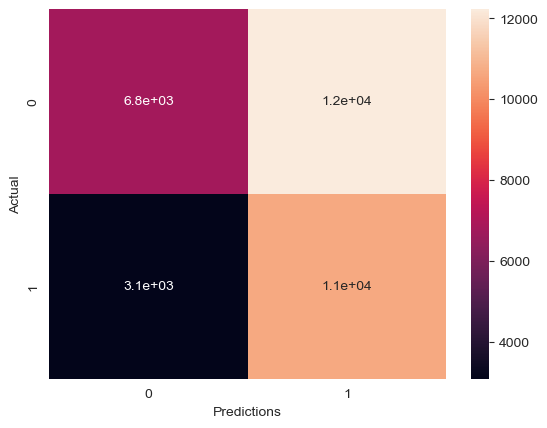


ROC AUC Curve 


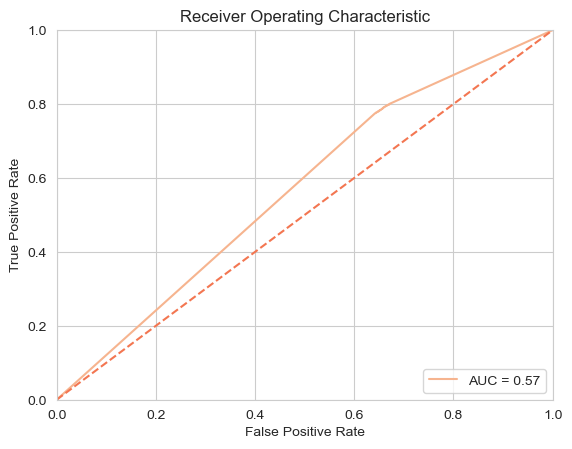


Precision Recall Curve 


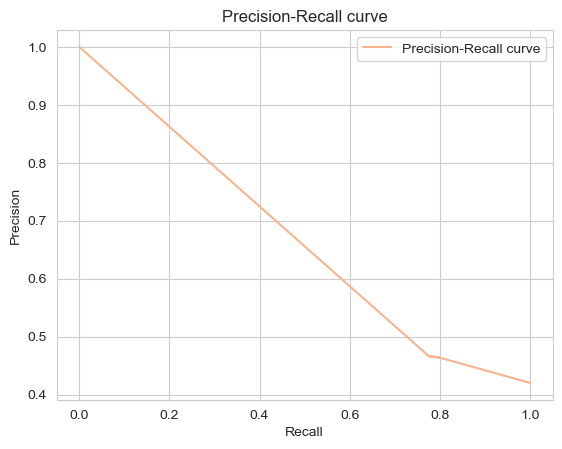

In [125]:
sgd = SGDClassifier()
params = {
    'loss': ['modified_huber', 'log_loss'],
    'penalty': ['elasticnet', 'l2'],
    'random_state': [SEED],
    'early_stopping': [True]
}

clf = GridSearchCV(sgd,params)
sgd_gc = evaluate_model(clf, X_train, y_train, X_test, y_test, graphs=True)

In [108]:
print(sgd_gc.best_params_)

{'early_stopping': True, 'loss': 'log_loss', 'penalty': 'elasticnet', 'random_state': None}


K Fold Cross Validation SGD with Optimal Parameters

In [109]:
params = {'early_stopping': True, 'loss': 'log_loss', 'penalty': 'l2', 'random_state': SEED}
k_fold(SGDClassifier(**params),5)

Fold accuracy: 0.733
Fold accuracy: 0.684
Fold accuracy: 0.552
Fold accuracy: 0.750
Fold accuracy: 0.728
Mean Accuracy: 0.689


Benchmark Random Forest

In [ ]:
rf = RandomForestClassifier()
evaluate_model(rf, X_train, y_train, X_test, y_test, graphs=False)

Random Forest


Classification Report 
              precision    recall  f1-score   support

           0       0.62      1.00      0.76     18995
           1       0.98      0.16      0.27     13766

    accuracy                           0.64     32761
   macro avg       0.80      0.58      0.52     32761
weighted avg       0.77      0.64      0.56     32761


Confusion Matrix 


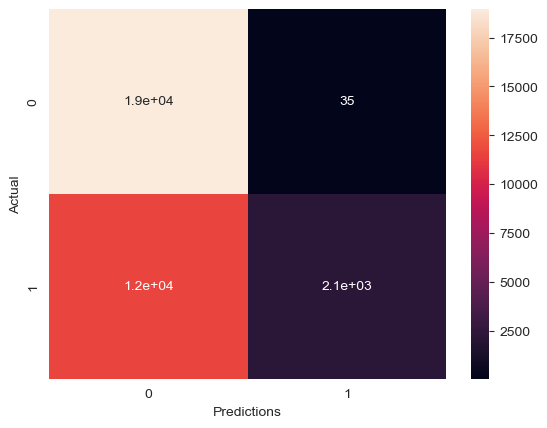


ROC AUC Curve 


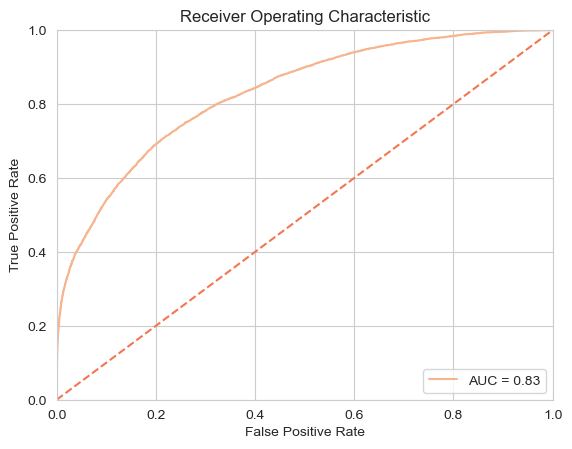


Precision Recall Curve 


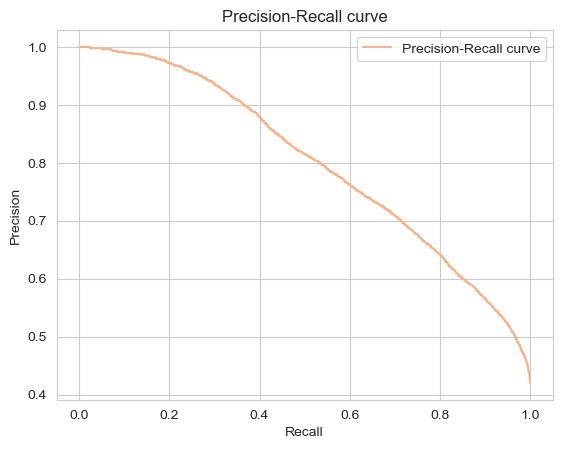

In [114]:
rf = RandomForestClassifier()

params  = {
    'n_estimators': [100, 200], # number of trees in the forest
    'max_depth': [4, 6], # max tree depth of each tree
    # 'min_samples_split': [2, 5, 10], # min samples required to split node
    # 'min_samples_leaf': [1, 2, 4], # min samples required to be at a leaf node
    #'max_features': ['sqrt', 'log2'] # number of features to consider when looking for the best split
}

clf = GridSearchCV(rf, params)
rf_gc = evaluate_model(clf, X_train, y_train, X_test, y_test, graphs=True)

In [115]:
rf_gc.best_params_

{'max_depth': 6, 'n_estimators': 200}

K Fold Cross Validation Random Forest with Optimal Parameters

In [116]:
k_fold(RandomForestClassifier(**rf_gc.best_params_), 5)

Fold accuracy: 0.643
Fold accuracy: 0.640
Fold accuracy: 0.634
Fold accuracy: 0.642
Fold accuracy: 0.642
Mean Accuracy: 0.640


Benchmark Adaboost


Classification Report 
              precision    recall  f1-score   support

           0       0.82      0.87      0.84     18995
           1       0.81      0.73      0.77     13766

    accuracy                           0.81     32761
   macro avg       0.81      0.80      0.80     32761
weighted avg       0.81      0.81      0.81     32761


Confusion Matrix 


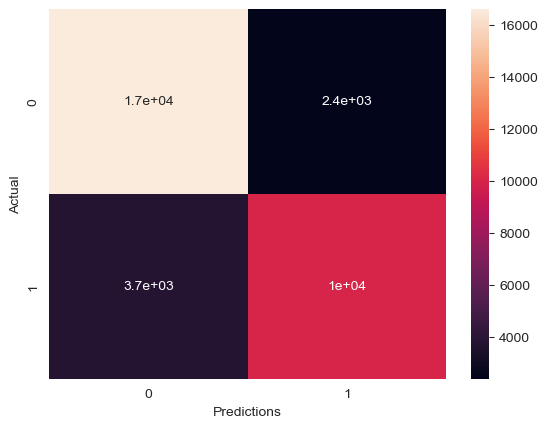


ROC AUC Curve 


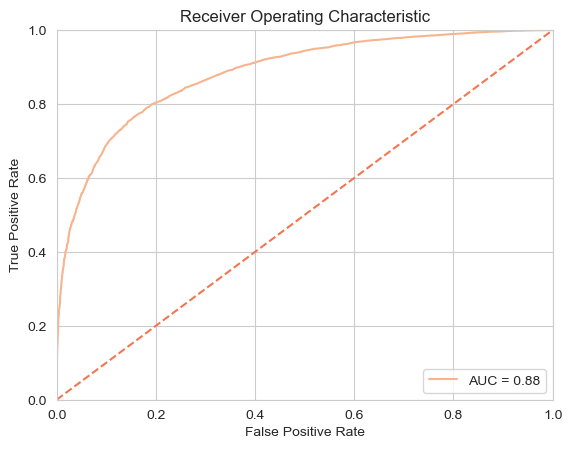


Precision Recall Curve 


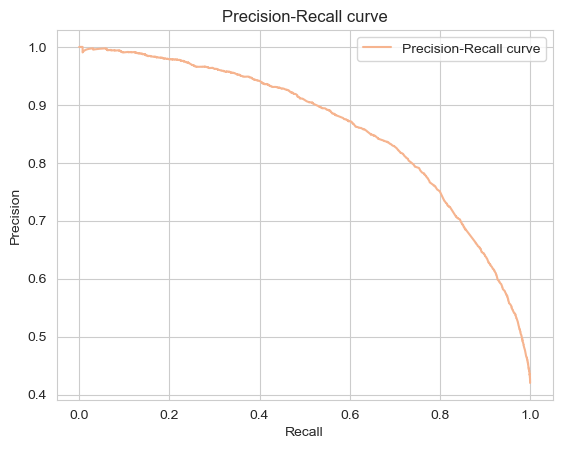

AdaBoostClassifier()

In [127]:
ada = AdaBoostClassifier()
evaluate_model(ada, X_train, y_train, X_test, y_test, graphs=True)

Gridsearch Adaboost

In [124]:
ada = AdaBoostClassifier()

params = {
   'learning_rate': [0.1, 0.001],
   'n_estimators' : [100,200]
}


clf = GridSearchCV(ada,params)
ada_gc = evaluate_model(clf, X_train, y_train, X_test, y_test, graphs=True)


KeyboardInterrupt: 

In [ ]:
ada_gc.best_params_

K Fold Cross Validation Adaboost with Optimal Parameters

In [ ]:
k_fold(AdaBoostClassifier(**ada_gc.best_params_), 5)